# 🔮 AI Taxonomy Inference (Interactive Selection)

**Features:**
* **Select Run ID:** Choose which trained model to use.
* **Safe Class Loading:** Reads `classes.json` from the run folder (prevents data drift).
* **Auto-Fix:** If `classes.json` is missing (old runs), it creates one from current data.
    
**Path:** /workspace/AiTaxonomy

In [1]:
import os
import glob
import json
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import random

# ================= CONFIGURATION =================
TFRECORD_BASE_PATH = r"/workspace/AiTaxonomy/TFRecords_AllSpecies_B6"
LOG_DIR = r"/workspace/AiTaxonomy/TF-Training-Logs-B6"
DATA_DIR = r"/workspace/Archive/All-Species" # Used ONLY for generating fallback classes.json

IMG_SIZE = (528, 528)
INPUT_SHAPE = (528, 528, 3)

# Force Single GPU/CPU for Inference
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# =================================================

print("✅ Config Loaded.")

2025-12-04 14:40:01.831288: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-04 14:40:01.870876: I tensorflow/core/platform/cpu_feature_guard.cc:211] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


✅ Config Loaded.


In [5]:
# =============================================================================
# 📝 1. Select Run ID & Load Class List
# =============================================================================

if not os.path.exists(TFRECORD_BASE_PATH):
    raise FileNotFoundError("❌ TFRecord path not found!")

available_ids = sorted(os.listdir(TFRECORD_BASE_PATH))
print(f"📂 Available Run IDs ({len(available_ids)} found):")
for i, run_id in enumerate(available_ids[-10:]): 
    print(f"   [{i+1}] {run_id}")

user_input = input("\n👉 Enter RUN ID (or press Enter for Latest): ").strip()
if user_input and user_input in available_ids:
    RUN_ID = user_input
else:
    RUN_ID = available_ids[-1]

print(f"\n✅ SELECTED: {RUN_ID}")

# --- LOAD CLASSES (SAFE MODE) ---
id_folder = os.path.join(TFRECORD_BASE_PATH, RUN_ID)
class_file = os.path.join(id_folder, "classes.json")

if os.path.exists(class_file):
    print("📂 Loading classes from saved JSON...")
    with open(class_file, 'r', encoding='utf-8') as f:
        class_names = json.load(f)
else:
    print("⚠️ classes.json NOT FOUND in Run folder (Old Run?)")
    print("⚙️ Generating fallback class list from DATA_DIR...")
    try:
        # Generate once and save it for future safety
        class_names = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])
        with open(class_file, "w", encoding="utf-8") as f:
            json.dump(class_names, f, ensure_ascii=False, indent=4)
        print(f"💾 Saved new classes.json to {class_file} (Future runs will use this).")
    except Exception as e:
        raise RuntimeError(f"❌ Could not generate class list. Check DATA_DIR. Error: {e}")

class_names.append("Dummy1")
class_names.append("Dummy2")

NUM_CLASSES = len(class_names)
print(f"✅ Loaded {NUM_CLASSES} classes.")

📂 Available Run IDs (1 found):
   [1] 20251203-065556



👉 Enter RUN ID (or press Enter for Latest):  20251203-065556



✅ SELECTED: 20251203-065556
📂 Loading classes from saved JSON...
✅ Loaded 544 classes.


In [6]:
# =============================================================================
# 📝 2. Load Phase 3 Weights
# =============================================================================

weights_path = os.path.join(LOG_DIR, f"B6_{RUN_ID}_P3.weights.h5")

if not os.path.exists(weights_path):
    # Try fallback naming (sometimes timestamp differs slightly if not passed correctly)
    # We search for any P3 weights containing the ID
    candidates = glob.glob(os.path.join(LOG_DIR, f"*{RUN_ID}*P3.weights.h5"))
    if candidates:
        weights_path = candidates[0]
    else:
        raise FileNotFoundError(f"❌ Weights file not found for ID {RUN_ID} in {LOG_DIR}")

print(f"⚖️ Weights found: {os.path.basename(weights_path)}")

def build_model():
    inputs = layers.Input(shape=INPUT_SHAPE)
    base_model = tf.keras.applications.EfficientNetB6(
        include_top=False, weights=None, input_tensor=inputs
    )
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='linear')(x)
    return keras.Model(inputs, outputs)

print("⏳ Building model & Loading weights...")
model = build_model()
model.load_weights(weights_path)
print("✅ Model Ready!")

⚖️ Weights found: B6_20251203-065556_P3.weights.h5
⏳ Building model & Loading weights...
✅ Model Ready!


In [9]:
# =============================================================================
# 📝 3. Prediction Function
# =============================================================================

def predict_image(image_path):
    if not os.path.exists(image_path):
        print(f"❌ File not found: {image_path}")
        return
    
    img = cv2.imread(image_path)
    if img is None:
        print("❌ Could not read image.")
        return
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, IMG_SIZE)
    img_batch = tf.expand_dims(img_resized, 0)
    
    logits = model.predict(img_batch, verbose=0)
    scores = tf.nn.softmax(logits[0])
    
    pred_idx = np.argmax(scores)
    pred_class = class_names[pred_idx]
    conf = 100 * np.max(scores)
    
    plt.figure(figsize=(5, 5))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f"{pred_class}\n{conf:.2f}%", color='green' if conf > 70 else 'orange')
    plt.show()
    
    # Top 3
    print(f"🔍 Result for: {os.path.basename(image_path)}")
    top3 = np.argsort(scores)[-3:][::-1]
    for i in top3:
        print(f"   - {class_names[i]}: {scores[i]*100:.2f}%")


Elaeocarpus hygrophilus - มะกอกน้ำ/N000798lfup02.JPG


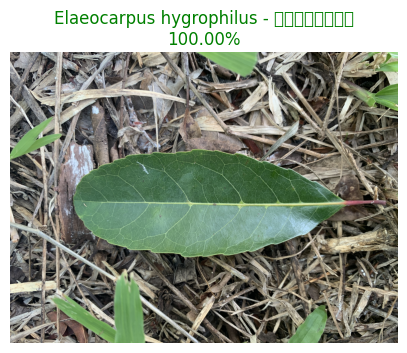

🔍 Result for: N000798lfup02.JPG
   - Elaeocarpus hygrophilus - มะกอกน้ำ: 100.00%
   - Anacardium occidentale - มะม่วงหิมพานต์: 0.00%
   - Streblus asper - ข่อย: 0.00%


In [20]:
# Test Random
test_cls = random.choice(class_names[:-2])
test_dir = os.path.join(DATA_DIR, test_cls)
if os.path.exists(test_dir):
    files = os.listdir(test_dir)
    if files:
        f = random.choice(files)
        print(os.path.join(test_cls, f))
        predict_image(os.path.join(test_dir, f))